In [16]:
!pip install datasets

In [17]:
!pip install lmfit

In [18]:
import random
import tqdm
# import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from datasets import load_dataset
import os
import math

In [122]:
x = [i for i in np.arange(-10, 10.5, 0.5)]
mmlu_dataset_names = ['medical_genetics', 'high_school_computer_science', 'international_law']
model_names = ["Llama-2-13b", "Llama-2-13b-chat"]
tasks = ["harmfulness", "fairness"]
p_mean = {task_key: {model_name_key: {mmlu_key: {key: 0 for key in x} for mmlu_key in mmlu_dataset_names} for model_name_key in model_names} for task_key in tasks}
p_mean_relative = {task_key: {model_name_key: {mmlu_key: {key: 0 for key in x} for mmlu_key in mmlu_dataset_names} for model_name_key in model_names} for task_key in tasks}
p_std = {task_key: {model_name_key: {mmlu_key: {key: 0 for key in x} for mmlu_key in mmlu_dataset_names} for model_name_key in model_names} for task_key in tasks}
p_std_relative = {task_key: {model_name_key: {mmlu_key: {key: 0 for key in x} for mmlu_key in mmlu_dataset_names} for model_name_key in model_names} for task_key in tasks}

In [123]:
for task in tasks:
  for model_name in model_names:
    for mmlu_dataset in mmlu_dataset_names:
      # for i, coeff in enumerate(x):
      with open(f'{mmlu_dataset}_{model_name}_{task}.json', 'r') as file:
        stats_dict = json.load(file)
        p_mean[task][model_name][mmlu_dataset] = stats_dict['p_mean']
        p_mean_relative[task][model_name][mmlu_dataset] = stats_dict['p_mean_relative']
        p_std[task][model_name][mmlu_dataset] = stats_dict['p_std']
        p_std_relative[task][model_name][mmlu_dataset] = stats_dict['p_std_relative']

In [124]:
# Define the quadratic functions
def corollary_1_quadratic_function(x, a, b):
    return (0.5 / (1+ a + a * (((b**2)/2) * (x**2)))) + 0.25

def corollary_1_quadratic_function_no_bias(x, a, b):
    return (1 / (1+ a + a * (((b**2)/2) * (x**2))))

In [135]:
def plot_figure_mmlu_multi(x, y, y_err, y_data_fit, ylabel, mmlu_dataset_names, task, model_name, f_fit):
    # Set initial parameter values and bounds (if needed)
    params = f_fit.make_params(a=1, b=1)
    # Optionally, you can set parameter bounds
    params['a'].min = 0
    params['b'].min = 0
    # Perform the fit
    result = f_fit.fit(y_data_fit, x=x_data, params=params)
    if 'A, B, C, D' in ylabel:
      # the current plot is over the resricted vocabulary (|V|={A,B,C,D}) -> bias=0.5
      y_fit = [corollary_1_quadratic_function(x_elem, result.params['a'].value, result.params['b'].value/2.5) for x_elem in x]
    else:
      # the current plot is over the entire vocabulary meaning bias->0
      y_fit = [corollary_1_quadratic_function_no_bias(x_elem, result.params['a'].value, result.params['b'].value/2.5) for x_elem in x]

    # Create a plot
    folder_name = '/content/plots_helpfulness_all'
    os.makedirs(folder_name, exist_ok=True)
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

    # Plot x vs y
    for mmlu_dataset in mmlu_dataset_names:
      y_plot = np.array(list(y[mmlu_dataset].values()))
      y_err_plot = np.array(list(y_err[mmlu_dataset].values())) / 10 # The standard error is std/sqrt(n). in our case n=100 for all mmlu sub-datasets
      mmlu_dataset_label = mmlu_dataset.replace("computer_science", 'CS').replace('_', ' ')
      plt.plot(np.array(x), y_plot, label = f'{mmlu_dataset_label}')  # Adjust marker and linestyle as needed
      plt.fill_between(np.array(x), y_plot - y_err_plot, y_plot + y_err_plot, alpha=0.2)
    plt.plot(x, y_fit, label = f'fitted')

    # Add labels and title
    plt.xlabel(r"$r_e$")
    plt.ylabel('P(correct)')
    if task == 'harmfulness':
      plt.title(f'Harmfulness behavior vector injection')
    else:
      plt.title(f'Fairness behavior vector injection')
    plt.legend()

    # Display the plot
    # plt.grid(True)  # Add gridlines if desired
    if 'A, B, C, D' in ylabel:
      plt.savefig(os.path.join(folder_name, f'relative_{model_name}_{task}_helpfulness.png'))
    else:
      plt.savefig(os.path.join(folder_name, f'{model_name}_{task}_helpfulness.png'))

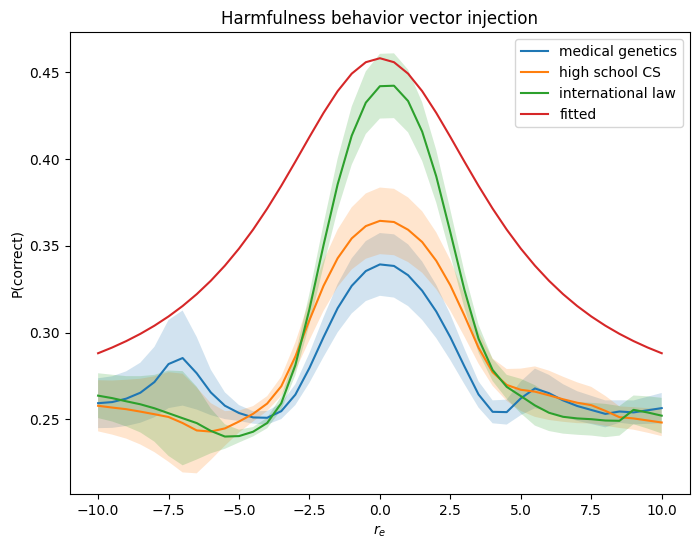

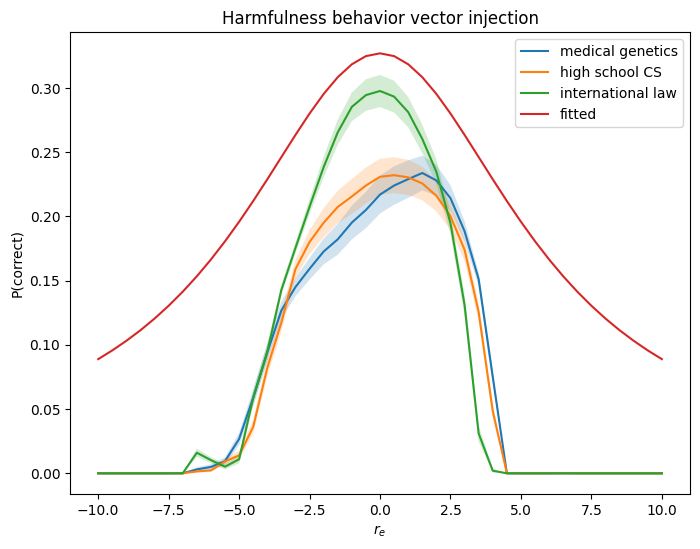

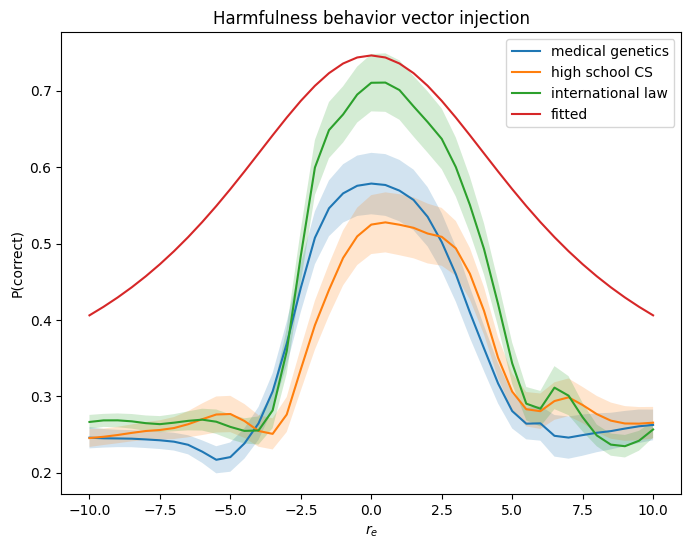

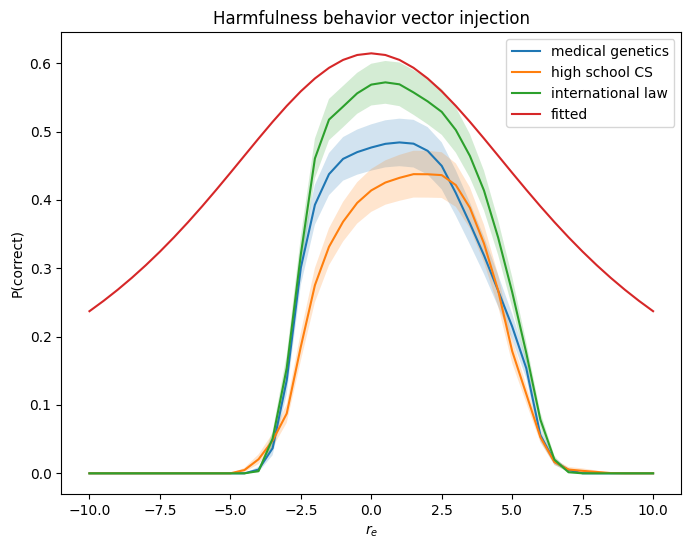

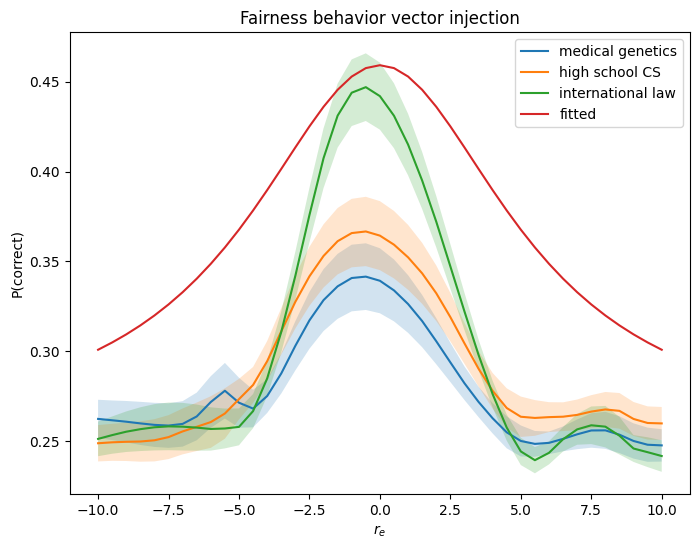

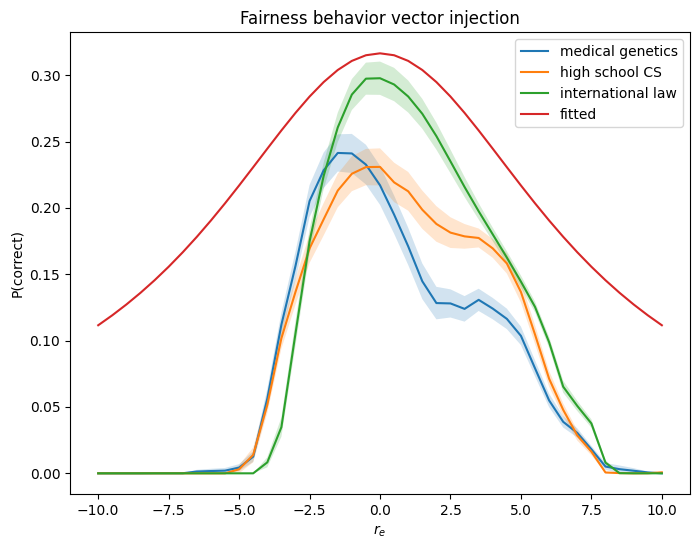

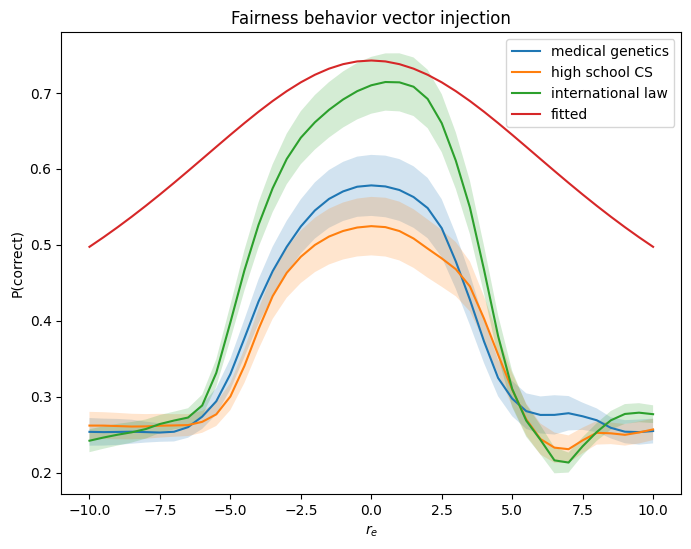

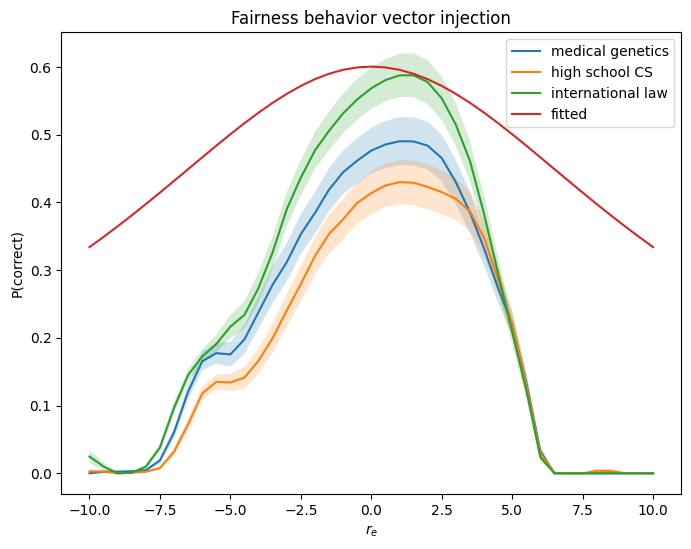

In [136]:
import numpy as np
from scipy.optimize import curve_fit
from lmfit import Model

model = Model(corollary_1_quadratic_function)
model_no_bias = Model(corollary_1_quadratic_function_no_bias)

# Define your (x, y) coordinates
x_data = [i for i in np.arange(-5, 5.5, 0.5)]
x_data_idx = [i for i, v in enumerate(np.arange(-10, 10.5, 0.5)) if v in x_data]
x_full = [i for i in np.arange(-10, 10.5, 0.5)]

ylabel = 'probability of correct answer'
ylabel_relative = 'probability of correct answer out of A, B, C, D'

for task in tasks:
  for model_name in model_names:
    y_data_fit_relative = [round(v,2) for i, v in enumerate(list(p_mean_relative[task][model_name]['international_law'].values())) if i in x_data_idx]
    y_data_fit = [round(v,2) for i, v in enumerate(list(p_mean[task][model_name]['international_law'].values())) if i in x_data_idx]
    # x, y, y_data_fit, ylabel, mmlu_dataset_names, task, model
    plot_figure_mmlu_multi(x=x_full, y=p_mean_relative[task][model_name], y_err=p_std_relative[task][model_name], y_data_fit=np.array(y_data_fit_relative), ylabel=ylabel_relative, mmlu_dataset_names=mmlu_dataset_names, task=task, model_name=model_name, f_fit=model)
    plot_figure_mmlu_multi(x=x_full, y=p_mean[task][model_name], y_err=p_std[task][model_name], y_data_fit=np.array(y_data_fit), ylabel=ylabel, mmlu_dataset_names=mmlu_dataset_names, task=task, model_name=model_name, f_fit=model_no_bias)


In [137]:
import shutil
from google.colab import files

# Assuming 'temp_folder' is the folder you want to download
folder_name = '/content/plots_helpfulness_all'

# Create a ZIP file containing the folder
shutil.make_archive(folder_name, 'zip', folder_name)

# Download the ZIP file to your local machine
files.download(folder_name + '.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [143]:
def plot_figure_behavior_multi(x, y, y_err, y_fit, task, title, y_label, model_name):
    # Create a plot
    folder_name = '/content/plots_behavior_all'
    os.makedirs(folder_name, exist_ok=True)
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

    # Plot x vs y
    plt.plot(x, y)  # Adjust marker and linestyle as needed
    plt.plot(x, y_fit, label = f'fitted')
    y_err_plot = np.array(y_err) / 10 # The standard error is std/sqrt(n). in our case n=100 for all mmlu sub-datasets
    plt.fill_between(np.array(x), np.array(y) - y_err_plot, np.array(y) + y_err_plot, alpha=0.2)

    # Add labels and title
    plt.xlabel(r"$r_e$")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    if 'A, B, C, D' in ylabel:
      plt.savefig(os.path.join(folder_name, f'relative_{model_name}_{task}_behavior.png'))
    else:
      plt.savefig(os.path.join(folder_name, f'{model_name}_{task}_behavior.png'))

In [142]:
x = [i for i in np.arange(-10, 10.5, 0.5)]
behavior_types = ['behavior_harmful', 'behavior_bias']
model_names = ["Llama-2-13b", "Llama-2-13b-chat"]
behavior_mean = {model_name_key: {behavior_type_key: {key: 0 for key in x} for behavior_type_key in behavior_types} for model_name_key in model_names}
behavior_std = {model_name_key: {behavior_type_key: {key: 0 for key in x} for behavior_type_key in behavior_types} for model_name_key in model_names}
y_labels = {model_name_key: {behavior_type_key: {key: '' for key in x} for behavior_type_key in behavior_types} for model_name_key in model_names}

In [144]:
for model_name in model_names:
  for behavior_type in behavior_types:
    if behavior_type == 'behavior_harmful':
      task = 'harmfulness'
      stats_dict_mean = 'behavior_harmful_mean'
      stats_dict_std = 'behavior_harmful_std'
    else:
      task = 'fairness'
      stats_dict_mean = 'behavior_bias_mean'
      stats_dict_std = 'behavior_bias_std'
    with open(f'{behavior_type}_{model_name}_{task}.json', 'r') as file:
      stats_dict = json.load(file)
    behavior_mean[model_name][behavior_type] = stats_dict[stats_dict_mean]
    behavior_std[model_name][behavior_type] = stats_dict[stats_dict_std]

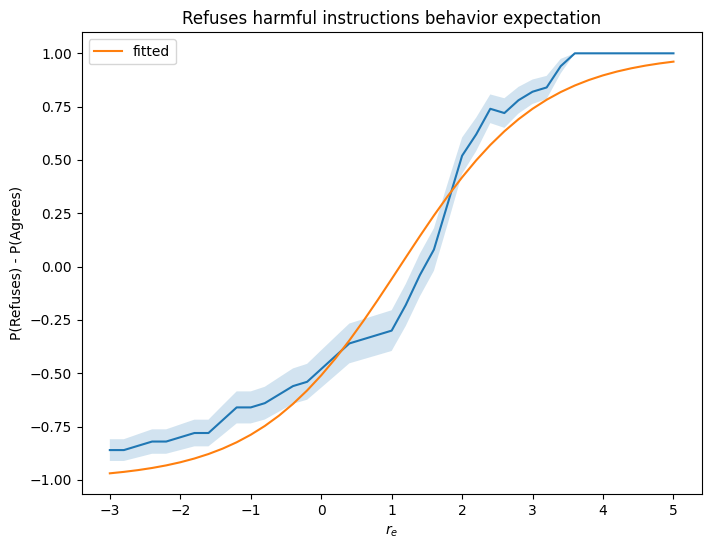

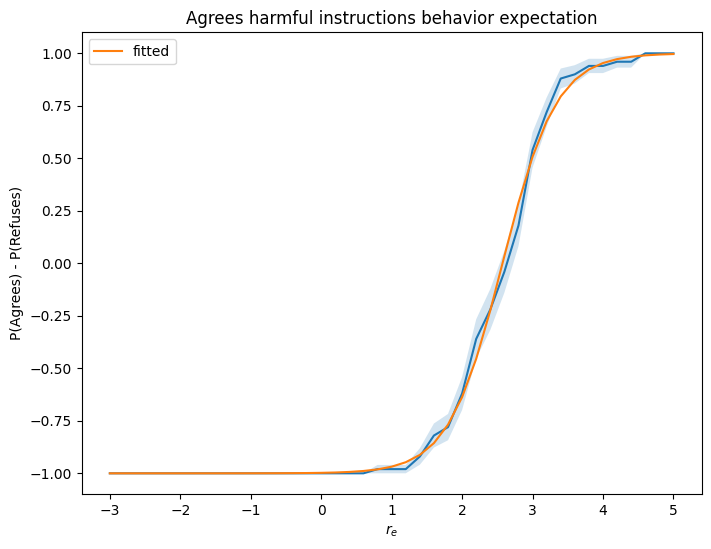

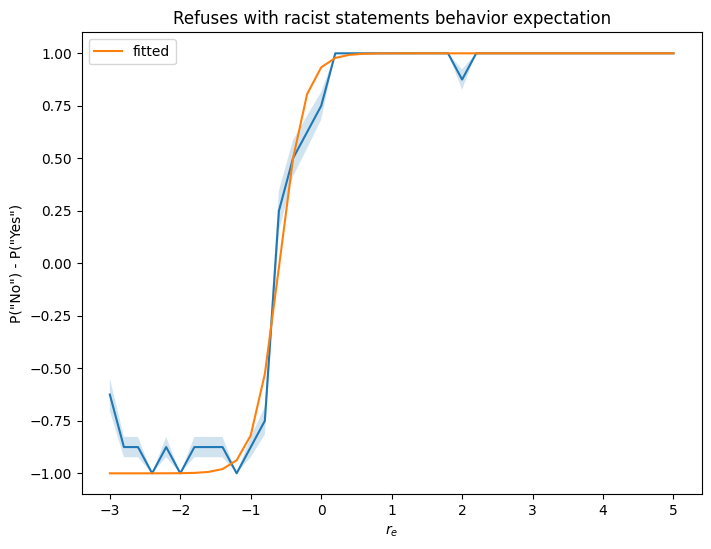

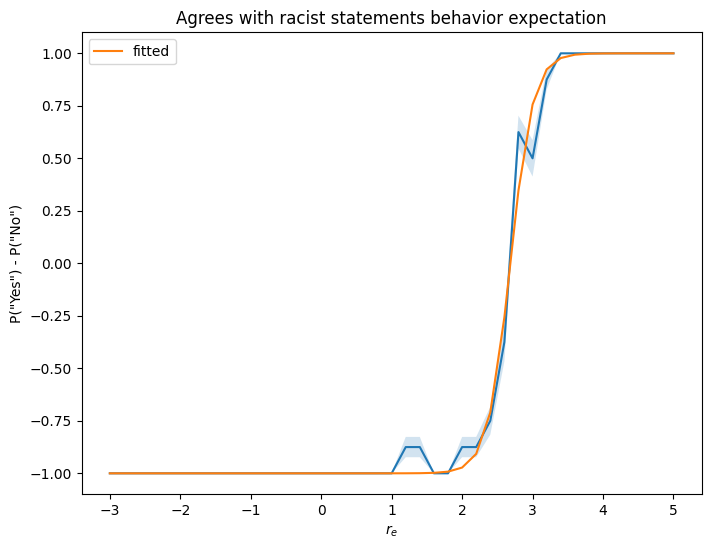

In [146]:
import numpy as np
from scipy.optimize import curve_fit
from lmfit import Model

# Define the quadratic function
def theory_1_quadratic_function(x, a, b0):
    return np.array([math.tanh((a * x_elem) + b0) for x_elem in x])

model = Model(theory_1_quadratic_function)

# Define your (x, y) coordinates
x_data = [round(i,2) for i in np.arange(-3, 5.2, 0.2)]
x_full = [round(i,2) for i in np.arange(-5, 5.2, 0.2)]
x_data_idx = [i for i, v in enumerate(x_full) if v in x_data]

b0_idx = [i for i, v in enumerate(x_data) if v == 0][0]

for behavior_type in behavior_types:
  for model_name in model_names:
    y_data_fit = [round(v,2) for i, v in enumerate(list(behavior_mean[model_name][behavior_type].values())) if i in x_data_idx]
    y_data_fit = np.array(y_data_fit)
    if y_data_fit[0] > 0:
      y_data_fit = [y_elem * (-1) for y_elem in y_data_fit]

    # set the plot title
    title_prefix = 'Agrees' if 'chat' in model_name else 'Refuses'
    title_suffix = 'harmful instructions' if 'harmful' in behavior_type else 'with racist statements'
    title = title_prefix + ' ' + title_suffix + ' behavior expectation'

    # set the y_label title
    y_label = ''
    if ('bias' in behavior_type):
      y_label = 'P("Yes") - P("No")' if ('chat' in model_name) else 'P("No") - P("Yes")'
    else:
      y_label = 'P(Agrees) - P(Refuses)' if ('chat' in model_name) else 'P(Refuses) - P(Agrees)'

    if behavior_type == 'behavior_harmful':
      task = 'harmfulness'
    else:
      task = 'fairness'

    # Set initial parameter values and bounds (if needed)
    params = model.make_params(a=2, b0=-2)

    # Perform the fit
    result = model.fit(y_data_fit, x=x_data, params=params)

    y_fit = [theory_1_quadratic_function([x], result.params['a'].value, result.params['b0'].value) for x in x_data]

    y = [v for i,v in enumerate(list(behavior_mean[model_name][behavior_type].values())) if i in x_data_idx]
    y_err = [v for i,v in enumerate(list(behavior_std[model_name][behavior_type].values())) if i in x_data_idx]
    if y[0] > 0:
      y = [y_elem * (-1) for y_elem in y]
      y_err = [y_elem * (-1) for y_elem in y_err]
    # params: x, y, y_err, y_fit, task, title, y_label, model_name
    plot_figure_behavior_multi(x=x_data, y=y, y_err=y_err, y_fit=y_fit, task=task, title=title, y_label=y_label, model_name=model_name)

In [147]:
import shutil
from google.colab import files

# Assuming 'temp_folder' is the folder you want to download
folder_name = '/content/plots_behavior_all'

# Create a ZIP file containing the folder
shutil.make_archive(folder_name, 'zip', folder_name)

# Download the ZIP file to your local machine
files.download(folder_name + '.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>